In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from dfdjaxGP import JaxDerviativeGP

import numpyro

import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_median,
    init_to_sample
)
import jax.numpy as jnp
from jax import random

/Users/mikegros/opt/anaconda3/envs/jaxgp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def true_f(x):
    return np.exp(-x*2)*np.sin(x*2.*np.pi)
def true_dfdx(x):
    return -2*np.exp(-2*x)*np.sin(x*2.*np.pi) + np.exp(-2*x)*np.cos(x*2.*np.pi)*2*np.pi
def true_d2fdx2(x):
    return 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2

n  = 3
dn = 10
pn = 50

x  = np.random.rand(n)
dx = np.random.rand(dn)

y  = true_f(x)
dy = true_dfdx(dx)

px  = np.linspace(0,1,pn)
py  = true_f(px)
pdy = true_dfdx(px)

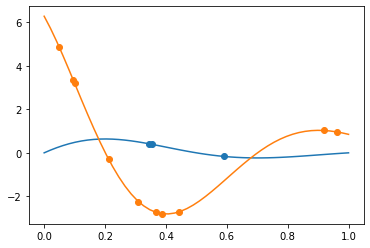

In [3]:
plt.scatter(x,y,c="C0")
plt.scatter(dx,dy,c="C1")
plt.plot(px,py)
plt.plot(px,pdy)


# JaxDerivativeGP with Bayesian inference for correlation length and marginal variance

- To account for uncertainty in these GP hyperparameters, I've set the code up to use numpyro to sample these parameters using HMC. This is pretty fast, not more than 10 or 20 seconds in my toy problems here

- Prediction is currently very slow however. I need to JIT some of the prediction functions to try to speed that up, but right now it is slow to loop through the 4000 samples and sample from the GP for each case.

In [4]:
jgp = JaxDerviativeGP(x, y)


In [5]:
def model(x, y, dx, dy):
    # set log-normal priors on our kernel hyperparameters
    var    = numpyro.sample("marg_var", dist.LogNormal(0.0, 1.0))
    length = numpyro.sample("corr_len", dist.LogNormal(0.0, 1.0))

    # compute kernel
    k00  = jgp.get_mixed_cov( x,  x, 0, 0, length, var)
    k00 += np.eye(x.shape[0])*1.e-4
    k11  = jgp.get_mixed_cov(dx, dx, 1, 1, length, var)
    k11 += np.eye(dx.shape[0])*1.e-4
    k01  = jgp.get_mixed_cov( x, dx, 0, 1, length, var)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k00),
        obs=y,
    )
    numpyro.sample(
        "dY",
        dist.MultivariateNormal(loc=k01.T @ jnp.linalg.inv(k00) @ y, covariance_matrix=k11 - k01.T @ jnp.linalg.inv(k00) @ k01),
        obs=dy,
    )

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
init_strategy = init_to_median(num_samples=10)
kernel        = NUTS(model, init_strategy=init_strategy)
mcmc = MCMC(
        kernel,
        num_warmup   = 500,
        num_samples  = 1000,
        num_chains   = 4,
        progress_bar = True,
    )
mcmc.run(rng_key, x, y, dx, dy)
mcmc.print_summary()
jgp.samples = mcmc.get_samples() 

/var/folders/hf/w7yy26v11hq25bshtjcppjxm000l4x/T/ipykernel_38011/1477863468.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|███████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1134.71it/s, 3 steps of size 5.65e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  corr_len      0.53      0.06      0.53      0.44      0.62   1333.66      1.00
  marg_var      1.96      1.33      1.62      0.46      3.67   1124.32      1.01

Number of divergences: 0


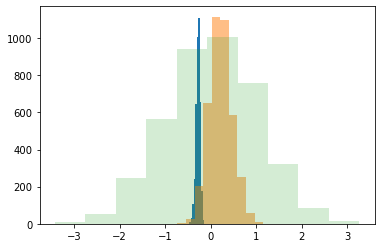

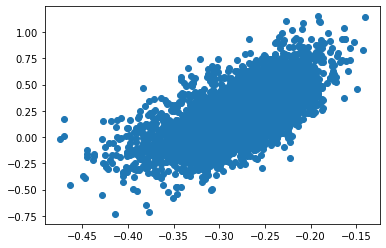

In [6]:
plt.hist(np.log10(np.array(jgp.samples["corr_len"])))
plt.hist(np.log10(np.array(jgp.samples["marg_var"])),alpha=0.5)
plt.hist(np.random.randn(4000), alpha=0.2)
plt.show()

plt.scatter(np.log10(np.array(jgp.samples["corr_len"])), np.log10(np.array(jgp.samples["marg_var"])))


In [7]:
def predict(x, y, dx, dy, x_test, deriv_num, var, length):
    # compute kernels between train and test data, etc.
    k00  = jgp.get_mixed_cov( x,  x, 0, 0, length, var)
    k00 += np.eye(x.shape[0])*1.e-4
    k11  = jgp.get_mixed_cov(dx, dx, 1, 1, length, var)
    k11 += np.eye(dx.shape[0])*1.e-4
    k01  = jgp.get_mixed_cov( x, dx, 0, 1, length, var)
    
    kobs = np.vstack([ np.hstack([k00, k01]), np.hstack([k01.T, k11])])
    
    knn  = jgp.get_mixed_cov(x_test, x_test, deriv_num, deriv_num, length, var)
    kno  = np.hstack([jgp.get_mixed_cov(x_test, x, deriv_num, 0, length, var),jgp.get_mixed_cov(x_test, dx, deriv_num, 1, length, var) ])

    mean  = kno @ np.linalg.inv(kobs) @ np.concatenate([y,dy])
    cov   = knn - kno @ np.linalg.inv(kobs) @ kno.T
    
    upper = mean + 2*np.sqrt(np.diag(cov))
    lower = mean - 2*np.sqrt(np.diag(cov))
    return mean, upper, lower

def sample(x, y, dx, dy, x_test, deriv_num, mvars, lengths):
    # compute kernels between train and test data, etc.
    n_samps = len(mvars)
    samps   = []
    for ii in range(n_samps):
        var    = mvars[ii]
        length = lengths[ii]
        
        k00  = jgp.get_mixed_cov( x,  x, 0, 0, length, var)
        k00 += np.eye(x.shape[0])*1.e-4
        k11  = jgp.get_mixed_cov(dx, dx, 1, 1, length, var)
        k11 += np.eye(dx.shape[0])*1.e-4
        k01  = jgp.get_mixed_cov( x, dx, 0, 1, length, var)

        kobs = np.vstack([ np.hstack([k00, k01]), np.hstack([k01.T, k11])])

        knn  = jgp.get_mixed_cov(x_test, x_test, deriv_num, deriv_num, length, var)
        kno  = np.hstack([jgp.get_mixed_cov(x_test, x, deriv_num, 0, length, var),jgp.get_mixed_cov(x_test, dx, deriv_num, 1, length, var) ])

        mean  = kno @ np.linalg.inv(kobs) @ np.concatenate([y,dy])
        cov   = knn - kno @ np.linalg.inv(kobs) @ kno.T + 1.e-6*np.eye(knn.shape[0])

        samps.append(mean + np.linalg.cholesky(cov) @ np.random.randn(len(mean)))
    return samps



In [8]:
%%time
y_hat, lower, upper = predict(x,y,dx,dy,px,0,np.mean(jgp.samples["marg_var"]), np.mean(jgp.samples["corr_len"]))


CPU times: user 585 ms, sys: 11.2 ms, total: 596 ms
Wall time: 596 ms


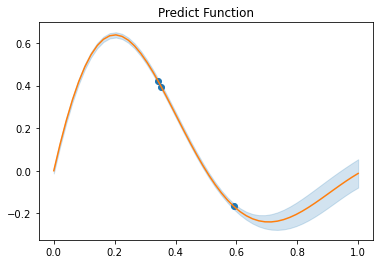

In [9]:
plt.scatter(x, y,c="C0")
plt.plot(px, y_hat, c="C1")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.title("Predict Function")
plt.show()


In [10]:
%%time
y_hat, lower, upper = predict(x,y,dx,dy,px,1, np.mean(jgp.samples["marg_var"]), np.mean(jgp.samples["corr_len"]))


CPU times: user 1.13 s, sys: 17.9 ms, total: 1.15 s
Wall time: 1.15 s


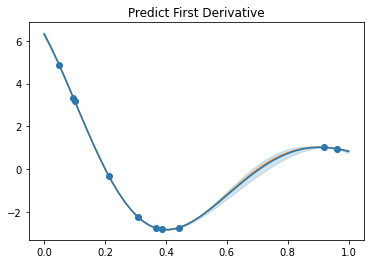

CPU times: user 101 ms, sys: 3.6 ms, total: 104 ms
Wall time: 103 ms


In [11]:
%%time
plt.scatter(dx, dy,c="C0")
plt.plot(px, pdy, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.title("Predict First Derivative")

plt.show()


In [12]:
%%time
y_hat, lower, upper = predict(x,y,dx,dy,px,2,np.mean(jgp.samples["marg_var"]), np.mean(jgp.samples["corr_len"]))


CPU times: user 1.86 s, sys: 27.6 ms, total: 1.89 s
Wall time: 1.89 s


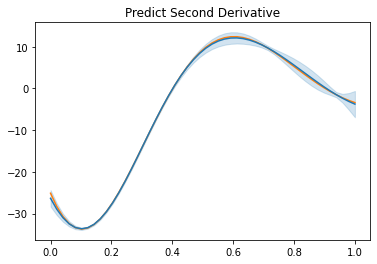

In [13]:
plt.plot(px, true_d2fdx2(px), c="C1")

plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.title("Predict Second Derivative")
plt.show()

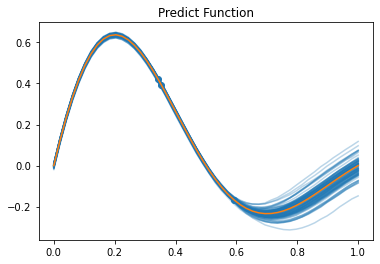

In [14]:

sample_f = np.array(sample(x,y,dx,dy,px,0,jgp.samples["marg_var"][:100], jgp.samples["corr_len"][:100]))

plt.scatter(x, y,c="C0",zorder=2)
plt.plot(px, py, c="C1",zorder=2)
plt.plot(px, sample_f.T, c="C0",alpha=0.3,zorder=1)
#plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.title("Predict Function")
plt.show()


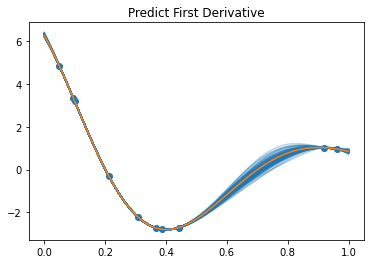

In [15]:
sample_f = np.array(sample(x,y,dx,dy,px,1,jgp.samples["marg_var"][:100], jgp.samples["corr_len"][:100]))

plt.scatter(dx, dy,c="C0",zorder=2)
plt.plot(px, pdy, c="C1",zorder=2)
plt.plot(px, sample_f.T, c="C0",alpha=0.3,zorder=1)
#plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.title("Predict First Derivative")
plt.show()


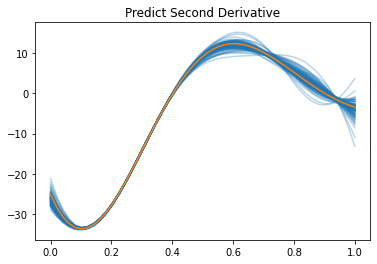

In [16]:
sample_f = np.array(sample(x,y,dx,dy,px,2,jgp.samples["marg_var"][:100], jgp.samples["corr_len"][:100]))

plt.plot(px, true_d2fdx2(px), c="C1",zorder=2)
plt.plot(px, sample_f.T, c="C0",alpha=0.3,zorder=1)
#plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.title("Predict Second Derivative")
plt.show()
